In [40]:
%matplotlib inline

In [41]:
import logging, imp
import dataset
import utils
import proxynca
import net

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib
import matplotlib.image as mpimg
matplotlib.use('agg', warn=False, force=True)
import matplotlib.pyplot as plt
import time
import argparse
import torchvision

from __future__ import print_function, division
from torch.autograd import Variable

import os
import copy

from PIL import Image
import PIL.Image
import evaluation
import random

plt.ion()  

## Visualize the data

The 'imshow' function averages the pixels over the image. Then I create a grid to visualize some of the images transformed and their class.

torch.FloatTensor


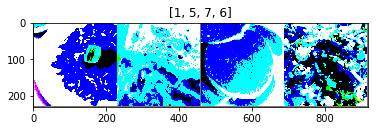

In [42]:
#To visualize the data
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    #print(type(inp))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) #Pause a bit so plots are updated

#DataLoader
dl_tr = torch.utils.data.DataLoader(
    dataset.Birds(
        root = 'upmc20', 
        labels = list(range(0, 10)), 
        transform = dataset.utils.make_transform()
    ),
    batch_size = 64,
    shuffle = True,
    num_workers = 16,
    drop_last = True,
    pin_memory = True
)

inputs, classes = next(iter(dl_tr))
print(inputs.type())
out = torchvision.utils.make_grid(inputs[0:4])
data_dir = 'upmc20' #Where I have the images saved

class_names = dl_tr.dataset.labels

imshow(out, title=[class_names[x] for x in classes[0:4]])

Shape of each image: (227, 227, 3)

## Make predictions

With the aid of an embedded model (embedded to 64 so each of the tensors have 64 characteristics) I find the closest 8 images to my instance and their classes.

In [43]:
def predict_batchwise(model, dataloader):
    with torch.no_grad():
        X, Y = zip(*[
            [x, y] for X, Y in dataloader #¿Itera por cada clase?
                for x, y in zip(
                    model(X.cuda()).cpu(), 
                    Y
                )
        ])
    return torch.stack(X), torch.stack(Y)

/home/rachu/miniconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


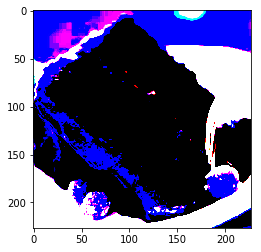

The indices of similar images are [587 589 568 574 527 570 518 514]


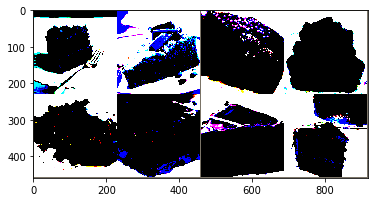

tensor(15)
[15 15 15 15 15 15 15 15]
['15.pancakes', '15.pancakes', '15.pancakes', '15.pancakes', '15.pancakes', '15.pancakes', '15.pancakes', '15.pancakes']
The lenght of Y is 1000
The lenght of T is 1000


In [48]:
model = net.bn_inception()
net.embed(model, 64) #Models the size of the tensor
model.load_state_dict(torch.load('saved/saved_model.pth'))
model = model.cuda()
model.eval() #Fixes the model

dl_ev = torch.utils.data.DataLoader(
    dataset.Birds(
        root = 'upmc20', 
        labels = list(range(10, 20)),
        transform = dataset.utils.make_transform(is_train = False)
    ),
    batch_size = 64,
    shuffle = False,
    num_workers = 16,
    pin_memory = True
)

rand = random.randint(1, 1001)
X, T = predict_batchwise(model, dl_ev) #X has an embedded size
Y, indices = evaluation.assign_by_euclidian_at_k_indices(X, T, 8) #Solo me devuelve las clases

imshow(dl_ev.dataset[rand][0]) #[1] contains the label of that image

print("The indices of similar images are %s" % indices[rand])
       
#imshow(out, title=[Y[rand]])
out = torchvision.utils.make_grid([dl_ev.dataset[i][0] for i in indices[rand]], nrow=4)
imshow(out) #
''' Imprimir los resultados a mano
print(X[800])
'''
print(T[rand])
print(Y[rand]) 

listing = sorted(os.listdir("./upmc20/images")) #to relocate the images
for i in range(10):
    position = 2
    item = listing.pop(position)
    listing.append(item)
    
#print(listing)

labels = [listing[i] for i in Y[rand]]

print(labels)
print("The lenght of Y is %d" % len(Y))
print("The lenght of T is %d" % len(T))

In [45]:
print(random.randint(1, 101))
out = torchvision.utils.make_grid(inputs[0:4])

95
